## Plotting activities

* Brute-force searches with 10% and 5% molar fractions
* Bayesian search 

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import sys
sys.path.append('../scripts')
from functions import *

### Load data

In [3]:
path = "../Activity_Estimation/"
filename = "PtAgAu_005_activities.csv"
n_metals = 3
molar_fractions, estimated_activities, estimated_max_eUs = load_csv_activity_data(path+filename)

In [4]:
# I need a function, that takes a list of lists and removes select "columns". By columns I mean the ones I can access if I transpose the 2-dimensional matrix (list of lists) and slice it there

molar_fractions_short = remove_columns(molar_fractions, [0, 1, 4])

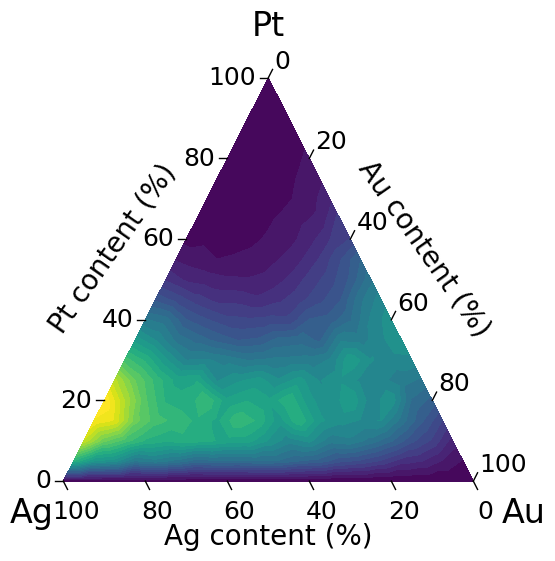

In [5]:
fig, ax = make_empty_plot()

fs = molar_fractions_short
zs = estimated_activities
ax = ax
elems = ["Ag", "Au", "Pt"]

make_ternary_contour_plot(fs, zs, ax, elems)

### PdAgAu only those three

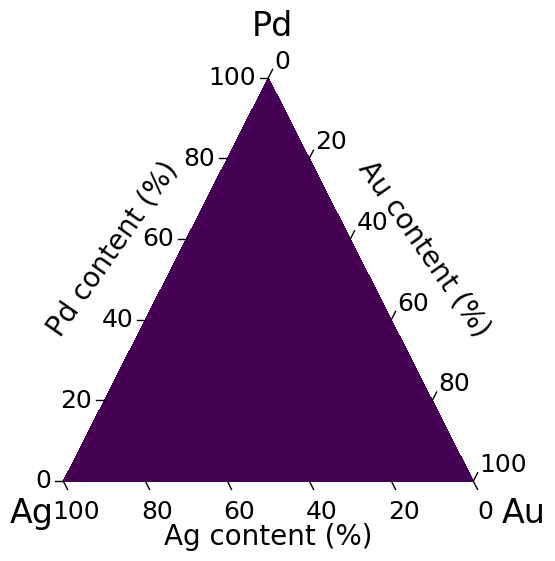

In [6]:
path = "../Activity_Estimation/"
filename = "PdAgAu_005_activities.csv"
n_metals = 3
molar_fractions, estimated_activities, estimated_max_eUs = load_csv_activity_data(path+filename)

molar_fractions_short = remove_columns(molar_fractions, [0, 1, 3])

fig, ax = make_empty_plot()

fs = molar_fractions_short
zs = estimated_activities
ax = ax
elems = ["Ag", "Au", "Pd"]

make_ternary_contour_plot(fs, zs, ax, elems, stand = False)

In [11]:
max(estimated_activities)

2.442902996335761e-10

### Same fraction of AgAuCu and Pd and Pt independently

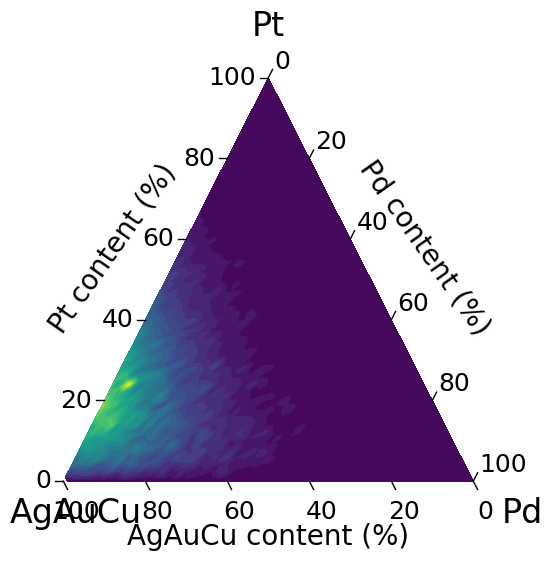

In [8]:
path = "../Activity_Estimation/"
filename = "AgAuCu_PdPt_001_activities.csv"
n_metals = 3
molar_fractions, estimated_activities, estimated_max_eUs = load_csv_activity_data(path+filename)

# Select just the three relevant metal columns
molar_fractions_AgAuCu_Pd_Pt = np.array(remove_columns(molar_fractions, [0, 3, 4]))
#molar_fractions_unadulterated = np.copy(molar_fractions_AgAuCu_Pd_Pt)

# In this case, one of the columns (0) represents both Ag, Au and Cu
# This column should be multiplied by 3 because the molar fraction represents
# all three metals
molar_fractions_AgAuCu_Pd_Pt.T[0] = molar_fractions_AgAuCu_Pd_Pt.T[0]*3

fig, ax = make_empty_plot()

fs = molar_fractions_AgAuCu_Pd_Pt
zs = estimated_activities
ax = ax
elems = ["AgAuCu", "Pd", "Pt"]

make_ternary_contour_plot(fs, zs, ax, elems)

In [5]:
# Is the colorbar consistent across different plots?

max(estimated_activities)

4.864462837576866e-06

In [64]:
metals

['Ag', 'Au', 'Cu', 'Pd', 'Pt']

In [16]:
molar_fractions_unadulterated

array([[0.33, 0.01, 0.  ],
       [0.33, 0.  , 0.01],
       [0.32, 0.04, 0.  ],
       ...,
       [0.  , 0.02, 0.98],
       [0.  , 0.01, 0.99],
       [0.  , 0.  , 1.  ]])

In [14]:
for molfrac in molar_fractions_AgAuCu_Pd_Pt.T[0]:
    print(molfrac)

0.99
0.99
0.96
0.96
0.96
0.96
0.96
0.9299999999999999
0.9299999999999999
0.9299999999999999
0.9299999999999999
0.9299999999999999
0.9299999999999999
0.9299999999999999
0.9299999999999999
0.8999999999999999
0.8999999999999999
0.8999999999999999
0.8999999999999999
0.8999999999999999
0.8999999999999999
0.8999999999999999
0.8999999999999999
0.8999999999999999
0.8999999999999999
0.8999999999999999
0.8699999999999999
0.8699999999999999
0.8699999999999999
0.8699999999999999
0.8699999999999999
0.8699999999999999
0.8699999999999999
0.8699999999999999
0.8699999999999999
0.8699999999999999
0.8699999999999999
0.8699999999999999
0.8699999999999999
0.8699999999999999
0.8400000000000001
0.8400000000000001
0.8400000000000001
0.8400000000000001
0.8400000000000001
0.8400000000000001
0.8400000000000001
0.8400000000000001
0.8400000000000001
0.8400000000000001
0.8400000000000001
0.8400000000000001
0.8400000000000001
0.8400000000000001
0.8400000000000001
0.8400000000000001
0.8400000000000001
0.81
0.81
0.81


In [37]:
molar_fractions_to_cartesians([[1.0, 0.0, 0.0]])
molar_fractions_to_cartesians([[0.0, 0.0, 1.0]])

array([[0.5      ],
       [0.8660254]])

In [6]:
path = "../Activity_Estimation/"
filename = "AgAuCu_PdPt_001_activities.csv"
n_metals = 3
molar_fractions, estimated_activities, estimated_max_eUs = load_csv_activity_data(path+filename)

In [8]:
max(estimated_activities)

4.864462837576866e-06